# imports

In [63]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# load data and create pandas table

In [64]:
job_name = "new_targets_SGD"
res = pd.read_pickle(job_name+"_results")

In [65]:
res

,r,sigma,n,L,lambda,Test MSE,Train MSE,Weight Decay,Learning Rate,Activations,...,Out-of-Distribution Squared Errors,Out-of-Distribution Generalization,Out-of-Distribution SEM,Out-of-Distribution STD of Squared Errors,Out-of-Distribution MSE$/\sigma^2$,Gradient Evaluations,Gradient Singular Values,Active Subspace,Active Subspace Distance,Principal Angle (Degrees)
0,1,0.00,64,2,0.00100,1.853891,"[60.244835, 60.12138, 59.998505, 59.876213, 59...","[1340.939, 1340.9382, 1340.9375, 1340.9373, 13...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[12.778694, 2.1107209, 4.0641823, 0.019065725,...",10.351309,0.327074,14.798062,NaN,"[[-0.40976685, 0.9622129, -8.681305, -3.010152...","[847.9721, 40.01336, 39.068718, 32.435616, 27....","[[0.017238101], [0.062443074], [-0.5836145], [...",0.168296,9.688765
1,1,0.25,64,2,0.00100,1.973737,"[60.175804, 60.053665, 59.932102, 59.81111, 59...","[1340.939, 1340.9382, 1340.9375, 1340.9373, 13...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[13.043413, 1.0868093, 5.4235945, 0.07556042, ...",10.731775,0.339158,15.344805,171.708405,"[[-0.32039592, 0.6996254, -8.477044, -3.083510...","[846.981, 41.753174, 38.25282, 32.74077, 27.01...","[[0.022068288], [0.056980763], [-0.58108777], ...",0.175457,10.105271
2,1,0.50,64,2,0.00100,2.288584,"[60.2153, 60.094467, 59.974205, 59.8545, 59.73...","[1340.939, 1340.9382, 1340.9376, 1340.9373, 13...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[13.484921, 4.3551126, 9.527143, 0.095186405, ...",11.494987,0.368288,16.662733,45.979950,"[[-0.4379928, 0.4984501, -8.276064, -3.1950605...","[846.12006, 45.248417, 38.455025, 33.3342, 29....","[[0.025958914], [0.051684607], [-0.5781451], [...",0.188215,10.848655
3,1,1.00,64,2,0.00100,3.514652,"[60.619934, 60.501663, 60.383938, 60.266766, 6...","[1340.9388, 1340.9382, 1340.9375, 1340.9369, 1...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[21.843136, 0.0006412862, 5.5919247, 0.6516610...",14.307076,0.455946,20.628731,14.307076,"[[-0.5344546, -0.07371, -8.082975, -3.408284, ...","[849.57495, 55.695873, 43.35957, 36.24292, 33....","[[0.033605464], [0.04243215], [-0.5701896], [-...",0.226581,13.095890
4,1,0.00,64,2,0.00010,1.859646,"[60.244835, 60.12138, 59.998505, 59.876213, 59...","[1340.9392, 1340.9387, 1340.9382, 1340.9382, 1...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[12.648987, 2.1346664, 4.0905952, 0.020423474,...",10.365108,0.327171,14.802446,NaN,"[[-0.41914958, 0.9541323, -8.717133, -3.025584...","[848.149, 40.314503, 39.27182, 32.716625, 27.7...","[[0.017258447], [0.062448375], [-0.5835747], [...",0.168451,9.697759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,1,1.00,64,9,0.00010,1.524175,"[60.684578, 60.673225, 60.66189, 60.65056, 60....","[29352.94, 29352.94, 29352.94, 29352.94, 29352...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[0.63950753, 5.1781077, 0.002493062, 0.3566836...",3.208056,0.111038,5.023762,3.208056,"[[0.11716798, 0.043266818, -5.6338673, -2.1990...","[990.7052, 21.73356, 0.21984667, 0.040153544, ...","[[-0.009714256], [0.01735621], [0.58569235], [...",0.116060,6.664744
92,1,0.00,64,9,0.00001,0.004998,"[60.332443, 60.320553, 60.308662, 60.296787, 6...","[29352.94, 29352.94, 29352.94, 29352.94, 29352...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[0.010616992, 0.0052116783, 0.0034634687, 0.00...",0.035010,0.002018,0.091297,NaN,"[[-0.080721706, 0.10600798, -6.095845, -1.6740...","[975.5314, 0.2812524, 0.059438594, 0.03112612,...","[[0.007826427], [-0.01040703], [0.5976749], [0...",0.004478,0.256585
93,1,0.25,64,9,0.00001,0.098505,"[60.257645, 60.24589, 60.234142, 60.222404, 60...","[29352.94, 29352.94, 29352.94, 29352.94, 29352...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[0.00039424084, 0.49276537, 0.08493561, 0.1556...",0.235466,0.008342,0.377406,3.767463,"[[-0.03958085, 0.0

# Check if Final Training Loss is Okay

In [66]:
trainMSE_threshold=1e-2
assert sum(res["Final Train MSE"] >= trainMSE_threshold + res["sigma"]) == 0

In [67]:
res = res[res["Final Train MSE"] < trainMSE_threshold + res["sigma"]] #filtering out bad fits

In [68]:
res

,r,sigma,n,L,lambda,Test MSE,Train MSE,Weight Decay,Learning Rate,Activations,...,Out-of-Distribution Squared Errors,Out-of-Distribution Generalization,Out-of-Distribution SEM,Out-of-Distribution STD of Squared Errors,Out-of-Distribution MSE$/\sigma^2$,Gradient Evaluations,Gradient Singular Values,Active Subspace,Active Subspace Distance,Principal Angle (Degrees)
0,1,0.00,64,2,0.00100,1.853891,"[60.244835, 60.12138, 59.998505, 59.876213, 59...","[1340.939, 1340.9382, 1340.9375, 1340.9373, 13...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[12.778694, 2.1107209, 4.0641823, 0.019065725,...",10.351309,0.327074,14.798062,NaN,"[[-0.40976685, 0.9622129, -8.681305, -3.010152...","[847.9721, 40.01336, 39.068718, 32.435616, 27....","[[0.017238101], [0.062443074], [-0.5836145], [...",0.168296,9.688765
1,1,0.25,64,2,0.00100,1.973737,"[60.175804, 60.053665, 59.932102, 59.81111, 59...","[1340.939, 1340.9382, 1340.9375, 1340.9373, 13...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[13.043413, 1.0868093, 5.4235945, 0.07556042, ...",10.731775,0.339158,15.344805,171.708405,"[[-0.32039592, 0.6996254, -8.477044, -3.083510...","[846.981, 41.753174, 38.25282, 32.74077, 27.01...","[[0.022068288], [0.056980763], [-0.58108777], ...",0.175457,10.105271
2,1,0.50,64,2,0.00100,2.288584,"[60.2153, 60.094467, 59.974205, 59.8545, 59.73...","[1340.939, 1340.9382, 1340.9376, 1340.9373, 13...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[13.484921, 4.3551126, 9.527143, 0.095186405, ...",11.494987,0.368288,16.662733,45.979950,"[[-0.4379928, 0.4984501, -8.276064, -3.1950605...","[846.12006, 45.248417, 38.455025, 33.3342, 29....","[[0.025958914], [0.051684607], [-0.5781451], [...",0.188215,10.848655
3,1,1.00,64,2,0.00100,3.514652,"[60.619934, 60.501663, 60.383938, 60.266766, 6...","[1340.9388, 1340.9382, 1340.9375, 1340.9369, 1...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[21.843136, 0.0006412862, 5.5919247, 0.6516610...",14.307076,0.455946,20.628731,14.307076,"[[-0.5344546, -0.07371, -8.082975, -3.408284, ...","[849.57495, 55.695873, 43.35957, 36.24292, 33....","[[0.033605464], [0.04243215], [-0.5701896], [-...",0.226581,13.095890
4,1,0.00,64,2,0.00010,1.859646,"[60.244835, 60.12138, 59.998505, 59.876213, 59...","[1340.9392, 1340.9387, 1340.9382, 1340.9382, 1...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[12.648987, 2.1346664, 4.0905952, 0.020423474,...",10.365108,0.327171,14.802446,NaN,"[[-0.41914958, 0.9541323, -8.717133, -3.025584...","[848.149, 40.314503, 39.27182, 32.716625, 27.7...","[[0.017258447], [0.062448375], [-0.5835747], [...",0.168451,9.697759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,1,1.00,64,9,0.00010,1.524175,"[60.684578, 60.673225, 60.66189, 60.65056, 60....","[29352.94, 29352.94, 29352.94, 29352.94, 29352...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[0.63950753, 5.1781077, 0.002493062, 0.3566836...",3.208056,0.111038,5.023762,3.208056,"[[0.11716798, 0.043266818, -5.6338673, -2.1990...","[990.7052, 21.73356, 0.21984667, 0.040153544, ...","[[-0.009714256], [0.01735621], [0.58569235], [...",0.116060,6.664744
92,1,0.00,64,9,0.00001,0.004998,"[60.332443, 60.320553, 60.308662, 60.296787, 6...","[29352.94, 29352.94, 29352.94, 29352.94, 29352...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[0.010616992, 0.0052116783, 0.0034634687, 0.00...",0.035010,0.002018,0.091297,NaN,"[[-0.080721706, 0.10600798, -6.095845, -1.6740...","[975.5314, 0.2812524, 0.059438594, 0.03112612,...","[[0.007826427], [-0.01040703], [0.5976749], [0...",0.004478,0.256585
93,1,0.25,64,9,0.00001,0.098505,"[60.257645, 60.24589, 60.234142, 60.222404, 60...","[29352.94, 29352.94, 29352.94, 29352.94, 29352...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[0.00039424084, 0.49276537, 0.08493561, 0.1556...",0.235466,0.008342,0.377406,3.767463,"[[-0.03958085, 0.0

# Tuning Hyperparameters

##  determine the lambda parameter that gets the best Validation MSE for each (r,n,L)

In [69]:
validationmse_vs_lambda = res.pivot_table(values="Validation Generalization",index = ("r","sigma","n","L","Activations"),columns=["lambda"])
validationmse_vs_lambda

lambda                     0.00001   0.00010   0.00100
r sigma n  L Activations                              
1 0.00  64 2 standard     1.766941  1.766355  1.760960
           3 standard     0.820430  0.819843  0.812594
           4 standard     0.084034  0.084059  0.084371
           5 standard     0.024535  0.024525  0.024446
           6 standard     0.010686  0.010679  0.010579
           7 standard     0.005749  0.005758  0.005796
           8 standard     0.005116  0.005119  0.005151
           9 standard     0.005132  0.005123  0.005153
  0.25  64 2 standard     1.923917  1.923342  1.917808
           3 standard     0.988115  0.987519  0.980089
           4 standard     0.194743  0.194721  0.194415
           5 standard     0.127276  0.127245  0.126995
           6 standard     0.112812  0.112774  0.112416
           7 standard     0.105454  0.105474  0.105280
           8 standard     0.103391  0.103388  0.103418
           9 standard     0.102920  0.102926  0.102977
  0.50  64 2 standard     2.329204  2.328685  2.323502
           3 standard     1.367041  1.366488  1.360548
           4 standard     0.558837  0.558609  0.556449
           5 standard     0.463747  0.463609  0.462195
           6 standard     0.447436  0.447322  0.446398
           7 standard     0.436326  0.436134  0.434121
           8 standard     0.416787  0.416692  0.415773
           9 standard     0.411091  0.411074  0.411085
  1.00  64 2 standard     3.710552  3.709777  3.701682
           3 standard     2.801211  2.800787  2.797073
           4 standard     2.096862  2.096442  2.091607
           5 standard     2.005104  2.004759  1.992048
           6 standard     1.890290  1.888769  1.874763
           7 standard     1.902853  1.901667  1.889208
           8 standard     1.810397  1.809113  1.795574
           9 standard     1.619159  1.617538  1.601961

In [70]:
bestlambda = validationmse_vs_lambda.idxmin(axis=1)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(bestlambda)

r  sigma  n   L  Activations
1  0.00   64  2  standard       0.00100
              3  standard       0.00100
              4  standard       0.00001
              5  standard       0.00100
              6  standard       0.00100
              7  standard       0.00001
              8  standard       0.00001
              9  standard       0.00010
   0.25   64  2  standard       0.00100
              3  standard       0.00100
              4  standard       0.00100
              5  standard       0.00100
              6  standard       0.00100
              7  standard       0.00100
              8  standard       0.00010
              9  standard       0.00001
   0.50   64  2  standard       0.00100
              3  standard       0.00100
              4  standard       0.00100
              5  standard       0.00100
              6  standard       0.00100
              7  standard       0.00100
              8  standard       0.00100
              9  standard       0.00010
   1.00   6

In [71]:
mask = [row["lambda"] == bestlambda[row["r"]][row["sigma"]][row["n"]][row["L"]][row["Activations"]] for rowindex,row in res.iterrows()]
res = res[mask]
res

,r,sigma,n,L,lambda,Test MSE,Train MSE,Weight Decay,Learning Rate,Activations,...,Out-of-Distribution Squared Errors,Out-of-Distribution Generalization,Out-of-Distribution SEM,Out-of-Distribution STD of Squared Errors,Out-of-Distribution MSE$/\sigma^2$,Gradient Evaluations,Gradient Singular Values,Active Subspace,Active Subspace Distance,Principal Angle (Degrees)
0,1,0.00,64,2,0.00100,1.853891,"[60.244835, 60.12138, 59.998505, 59.876213, 59...","[1340.939, 1340.9382, 1340.9375, 1340.9373, 13...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[12.778694, 2.1107209, 4.0641823, 0.019065725,...",10.351309,0.327074,14.798062,NaN,"[[-0.40976685, 0.9622129, -8.681305, -3.010152...","[847.9721, 40.01336, 39.068718, 32.435616, 27....","[[0.017238101], [0.062443074], [-0.5836145], [...",0.168296,9.688765
1,1,0.25,64,2,0.00100,1.973737,"[60.175804, 60.053665, 59.932102, 59.81111, 59...","[1340.939, 1340.9382, 1340.9375, 1340.9373, 13...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[13.043413, 1.0868093, 5.4235945, 0.07556042, ...",10.731775,0.339158,15.344805,171.708405,"[[-0.32039592, 0.6996254, -8.477044, -3.083510...","[846.981, 41.753174, 38.25282, 32.74077, 27.01...","[[0.022068288], [0.056980763], [-0.58108777], ...",0.175457,10.105271
2,1,0.50,64,2,0.00100,2.288584,"[60.2153, 60.094467, 59.974205, 59.8545, 59.73...","[1340.939, 1340.9382, 1340.9376, 1340.9373, 13...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[13.484921, 4.3551126, 9.527143, 0.095186405, ...",11.494987,0.368288,16.662733,45.979950,"[[-0.4379928, 0.4984501, -8.276064, -3.1950605...","[846.12006, 45.248417, 38.455025, 33.3342, 29....","[[0.025958914], [0.051684607], [-0.5781451], [...",0.188215,10.848655
3,1,1.00,64,2,0.00100,3.514652,"[60.619934, 60.501663, 60.383938, 60.266766, 6...","[1340.9388, 1340.9382, 1340.9375, 1340.9369, 1...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[21.843136, 0.0006412862, 5.5919247, 0.6516610...",14.307076,0.455946,20.628731,14.307076,"[[-0.5344546, -0.07371, -8.082975, -3.408284, ...","[849.57495, 55.695873, 43.35957, 36.24292, 33....","[[0.033605464], [0.04243215], [-0.5701896], [-...",0.226581,13.095890
12,1,0.00,64,3,0.00100,0.807108,"[60.49385, 60.4607, 60.42758, 60.3945, 60.3614...","[3341.8665, 3341.8652, 3341.8643, 3341.8633, 3...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[1.4786226, 0.7576961, 3.3744004, 8.695595, 0....",5.738575,0.189595,8.578014,NaN,"[[-0.30716375, -0.08213304, -4.0609007, -1.293...","[885.78546, 47.780212, 34.422344, 20.19713, 17...","[[0.0025478401], [-0.038257796], [0.59228146],...",0.094283,5.410051
13,1,0.25,64,3,0.00100,0.943158,"[60.415447, 60.382584, 60.349754, 60.316963, 6...","[3341.8665, 3341.8652, 3341.864, 3341.8633, 33...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[3.345787, 0.06628841, 4.4125576, 10.285237, 0...",6.093431,0.193123,8.737633,97.494888,"[[-0.2849964, -0.046169475, -4.1054106, -1.471...","[881.8918, 48.02421, 37.269688, 20.71083, 17.5...","[[0.0048375945], [0.036774468], [-0.58976525],...",0.106871,6.134996
14,1,0.50,64,3,0.00100,1.290468,"[60.445583, 60.413006, 60.380463, 60.347954, 6...","[3341.8667, 3341.8652, 3341.8643, 3341.8633, 3...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[6.1566052, 1.2520915, 7.505153, 5.4033914, 0....",6.885275,0.205778,9.310193,27.541101,"[[-0.25189617, -0.14080587, -3.8917549, -1.551...","[877.4041, 50.31013, 43.04648, 22.940956, 18.2...","[[0.01225655], [0.035559867], [-0.5870621], [-...",0.128055,7.357188
15,1,1.00,64,3,0.00100,2.630930,"[60.831497, 60.79947, 60.76748, 60.735516, 60....","[3341.8667, 3341.8652, 3341.8643, 3341.8633, 3...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[19.987255, 1.280997, 4.781752, 7.674028, 0.87...",10.322027,0.310608,14.053064,10.322027,"[[-0.35273415, -0.2852112, -3.8830996, -1.8451...","[870.4746, 66.286224, 53.540688, 35.485424, 2

##  determine the L parameter that gets the best validation MSE for each (r,n)

In [72]:
validationmse_vs_L = res.pivot_table(values="Validation Generalization",index = ("r","sigma","n","Activations"),columns=["L"])
validationmse_vs_L = validationmse_vs_L.iloc[:,1:]
bestL = validationmse_vs_L.idxmin(axis=1)
pd.concat((validationmse_vs_L,bestL),axis=1)

3         4         5         6         7  \
r sigma n  Activations                                                     
1 0.00  64 standard     0.812594  0.084034  0.024446  0.010579  0.005749   
  0.25  64 standard     0.980089  0.194415  0.126995  0.112416  0.105280   
  0.50  64 standard     1.360548  0.556449  0.462195  0.446398  0.434121   
  1.00  64 standard     2.797073  2.091607  1.992048  1.874763  1.889208   

                               8         9  0  
r sigma n  Activations                         
1 0.00  64 standard     0.005116  0.005123  8  
  0.25  64 standard     0.103388  0.102920  9  
  0.50  64 standard     0.415773  0.411074  9  
  1.00  64 standard     1.795574  1.601961  9

In [73]:
mask = [row["L"] == bestL[row["r"]][row["sigma"]][row["n"]][row["Activations"]] for rowindex,row in res.iterrows()]
bestLres = res[mask]
bestLres

,r,sigma,n,L,lambda,Test MSE,Train MSE,Weight Decay,Learning Rate,Activations,...,Out-of-Distribution Squared Errors,Out-of-Distribution Generalization,Out-of-Distribution SEM,Out-of-Distribution STD of Squared Errors,Out-of-Distribution MSE$/\sigma^2$,Gradient Evaluations,Gradient Singular Values,Active Subspace,Active Subspace Distance,Principal Angle (Degrees)
80,1,0.00,64,8,0.00001,0.004927,"[60.220078, 60.208218, 60.196358, 60.184513, 6...","[23350.545, 23350.545, 23350.545, 23350.541, 2...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[0.012421572, 0.0054785586, 0.002894708, 0.005...",0.036447,0.002085,0.094312,NaN,"[[-0.080969244, 0.10794863, -6.102233, -1.6674...","[974.7658, 0.8755918, 0.10221034, 0.05599428, ...","[[0.0077016023], [-0.010569922], [0.5975316], ...",0.004427,0.253656
87,1,1.00,64,9,0.00100,1.507665,"[60.684578, 60.673225, 60.66189, 60.65056, 60....","[29352.936, 29352.922, 29352.92, 29352.918, 29...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[0.6708645, 5.152551, 9.77288e-05, 0.35519493,...",3.155505,0.109665,4.961663,3.155505,"[[0.108174115, 0.015626028, -5.6341796, -2.155...","[989.6443, 18.088137, 0.19841528, 0.036225133,...","[[-0.009671373], [0.01677066], [0.5856356], [0...",0.115340,6.623226
90,1,0.50,64,9,0.00010,0.369733,"[60.2914, 60.279785, 60.268173, 60.25657, 60.2...","[29352.94, 29352.94, 29352.94, 29352.94, 29352...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[0.0009977765, 0.017939344, 0.94955117, 0.0721...",0.789682,0.027299,1.235104,3.158729,"[[-0.0021554828, 0.0067290403, -5.9081783, -1....","[981.6449, 1.8084933, 0.08660476, 0.045589, 0....","[[0.00040482456], [-0.001316256], [-0.5929043]...",0.057318,3.285856
93,1,0.25,64,9,0.00001,0.098505,"[60.257645, 60.24589, 60.234142, 60.222404, 60...","[29352.94, 29352.94, 29352.94, 29352.94, 29352...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[0.00039424084, 0.49276537, 0.08493561, 0.1556...",0.235466,0.008342,0.377406,3.767463,"[[-0.03958085, 0.044979602, -6.033347, -1.7796...","[978.6788, 0.58437943, 0.053533528, 0.03570398...","[[0.0035650982], [-0.0038073107], [0.59553075]...",0.030457,1.745352


In [74]:
bestLres.sort_values(by=['r','n',"sigma"])

,r,sigma,n,L,lambda,Test MSE,Train MSE,Weight Decay,Learning Rate,Activations,...,Out-of-Distribution Squared Errors,Out-of-Distribution Generalization,Out-of-Distribution SEM,Out-of-Distribution STD of Squared Errors,Out-of-Distribution MSE$/\sigma^2$,Gradient Evaluations,Gradient Singular Values,Active Subspace,Active Subspace Distance,Principal Angle (Degrees)
80,1,0.00,64,8,0.00001,0.004927,"[60.220078, 60.208218, 60.196358, 60.184513, 6...","[23350.545, 23350.545, 23350.545, 23350.541, 2...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[0.012421572, 0.0054785586, 0.002894708, 0.005...",0.036447,0.002085,0.094312,NaN,"[[-0.080969244, 0.10794863, -6.102233, -1.6674...","[974.7658, 0.8755918, 0.10221034, 0.05599428, ...","[[0.0077016023], [-0.010569922], [0.5975316], ...",0.004427,0.253656
93,1,0.25,64,9,0.00001,0.098505,"[60.257645, 60.24589, 60.234142, 60.222404, 60...","[29352.94, 29352.94, 29352.94, 29352.94, 29352...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[0.00039424084, 0.49276537, 0.08493561, 0.1556...",0.235466,0.008342,0.377406,3.767463,"[[-0.03958085, 0.044979602, -6.033347, -1.7796...","[978.6788, 0.58437943, 0.053533528, 0.03570398...","[[0.0035650982], [-0.0038073107], [0.59553075]...",0.030457,1.745352
90,1,0.50,64,9,0.00010,0.369733,"[60.2914, 60.279785, 60.268173, 60.25657, 60.2...","[29352.94, 29352.94, 29352.94, 29352.94, 29352...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[0.0009977765, 0.017939344, 0.94955117, 0.0721...",0.789682,0.027299,1.235104,3.158729,"[[-0.0021554828, 0.0067290403, -5.9081783, -1....","[981.6449, 1.8084933, 0.08660476, 0.045589, 0....","[[0.00040482456], [-0.001316256], [-0.5929043]...",0.057318,3.285856
87,1,1.00,64,9,0.00100,1.507665,"[60.684578, 60.673225, 60.66189, 60.65056, 60....","[29352.936, 29352.922, 29352.92, 29352.918, 29...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",standard,...,"[0.6708645, 5.152551, 9.77288e-05, 0.35519493,...",3.155505,0.109665,4.961663,3.155505,"[[0.108174115, 0.015626028, -5.6341796, -2.155...","[989.6443, 18.088137, 0.19841528, 0.036225133,...","[[-0.009671373], [0.01677066], [0.5856356], [0...",0.115340,6.623226


## What are the chosen lambda and L for each model?

In [75]:
bestres = pd.concat((res[res["L"] == 2],bestLres))

In [76]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(bestres.loc[:,:"lambda"].pivot_table(index=["r","sigma","n","L"],values=["lambda"]))

lambda
r sigma n  L         
1 0.00  64 2  0.00100
           8  0.00001
  0.25  64 2  0.00100
           9  0.00001
  0.50  64 2  0.00100
           9  0.00010
  1.00  64 2  0.00100
           9  0.00100

# Plotting

In [77]:
fontname = "Times New Roman"
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

## plots of all the singular values

1,64,2 [18.737713    0.8841787   0.86330485  0.7167326   0.60831356  0.5633543
  0.5218613   0.4649753   0.43235552  0.42556593  0.3754442   0.3690111
  0.303372    0.28869537  0.25302565  0.24474743  0.22344175  0.20363092
  0.18129125  0.16278751] 0 0
1,64,3 [19.573278    1.0558035   0.7606335   0.44629773  0.38677126  0.3464549
  0.27012357  0.24944918  0.20243768  0.18618086  0.13477877  0.12677461
  0.10402565  0.10281192  0.0950826   0.07949883  0.0720865   0.06750323
  0.06535204  0.05466036] 0 0
1,64,4 [2.12654133e+01 5.08536696e-01 1.55879885e-01 1.35717168e-01
 1.04870245e-01 9.15583000e-02 8.30890387e-02 7.90827796e-02
 6.98102787e-02 5.64203262e-02 5.18119819e-02 4.39970680e-02
 3.54018100e-02 3.42475325e-02 3.21268551e-02 2.93029360e-02
 2.64650900e-02 2.10088324e-02 1.93717051e-02 1.77049562e-02] 0 0
1,64,5 [2.1462009e+01 2.5614357e-01 4.6051186e-02 3.0184941e-02 2.5699811e-02
 2.3914956e-02 2.3224156e-02 1.9752875e-02 1.6377626e-02 1.4625458e-02
 1.4322826e-02 1.2330636e

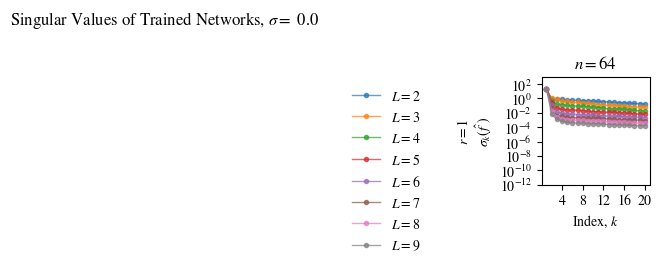

1,64,2 [18.715813    0.9226235   0.8452759   0.72347564  0.5968693   0.59046984
  0.5421353   0.47191393  0.46103263  0.42532736  0.39373088  0.36674175
  0.30919975  0.28367713  0.26413223  0.2534034   0.21950011  0.19279604
  0.17737976  0.16234449] 0 0
1,64,3 [19.48724     1.0611953   0.82355154  0.45764902  0.38825345  0.34359238
  0.3120762   0.2587359   0.20642313  0.19918586  0.17490403  0.12775078
  0.12683116  0.11113569  0.09778816  0.08747642  0.07960794  0.07144699
  0.06287271  0.06088326] 0 0
1,64,4 [2.1196728e+01 5.7293093e-01 2.5469846e-01 1.5251461e-01 1.2119421e-01
 1.0274324e-01 8.5645169e-02 8.0973968e-02 6.7831501e-02 5.9182696e-02
 5.5863351e-02 4.6268929e-02 4.2901900e-02 3.6350276e-02 3.4826107e-02
 3.0126059e-02 2.8811868e-02 2.4730742e-02 2.0883143e-02 1.6885480e-02] 0 0
1,64,5 [2.1480116e+01 3.4743798e-01 8.5159883e-02 4.1254245e-02 2.8872002e-02
 2.7856834e-02 2.1710392e-02 2.1470981e-02 1.9960646e-02 1.7450096e-02
 1.5389993e-02 1.4589722e-02 1.3113950e-02 

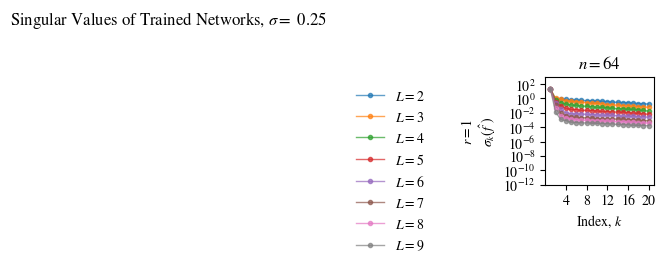

1,64,2 [18.696789    0.9998582   0.849744    0.7365888   0.6527164   0.6093827
  0.54170555  0.5141396   0.4713672   0.42954388  0.41296908  0.36767176
  0.31023768  0.2814541   0.27546874  0.26321173  0.22527124  0.1853295
  0.18065707  0.16884993] 0 0
1,64,3 [19.388075    1.1117073   0.9512018   0.5069283   0.40226844  0.36698696
  0.34905368  0.280499    0.27024773  0.20310076  0.19174853  0.15475476
  0.12991278  0.12182406  0.10242396  0.09441424  0.08520526  0.08014772
  0.07147346  0.06231846] 0 0
1,64,4 [21.050207    0.78405565  0.51539147  0.27380887  0.16649137  0.14743376
  0.10773904  0.10092269  0.09269492  0.07439276  0.06701619  0.05773517
  0.04624479  0.04067166  0.03759889  0.035037    0.03162133  0.02929947
  0.02565667  0.02298196] 0 0
1,64,5 [2.1487885e+01 6.5888196e-01 2.8066385e-01 7.4647263e-02 5.1840905e-02
 4.2279329e-02 3.9119989e-02 3.0912409e-02 2.6032679e-02 2.0678805e-02
 1.9343363e-02 1.9035265e-02 1.7834717e-02 1.4086228e-02 1.4067757e-02
 1.2455467e-02

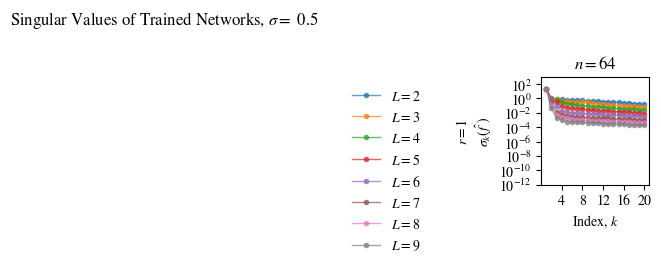

1,64,2 [18.773132    1.2307166   0.95812017  0.80086297  0.74034315  0.67696756
  0.65283966  0.55259436  0.50500196  0.46124917  0.4374512   0.36609808
  0.32825762  0.3152445   0.30724564  0.24890652  0.24207635  0.21542343
  0.17936464  0.17339037] 0 0
1,64,3 [19.234953    1.4647325   1.1830932   0.7841245   0.50407606  0.47688845
  0.41886917  0.3761334   0.28923836  0.23374656  0.21079485  0.18739995
  0.16688164  0.14286187  0.13387904  0.12108412  0.09758243  0.08549568
  0.0791995   0.07008024] 0 0
1,64,4 [20.738985    1.3994945   1.1462814   0.7118389   0.49056348  0.2669909
  0.18861492  0.15395164  0.11958078  0.10247565  0.08330196  0.07795247
  0.07203221  0.05833821  0.05465911  0.04633761  0.04067411  0.04023507
  0.03667912  0.03265595] 0 0
1,64,5 [2.12320347e+01 1.72434831e+00 1.32719362e+00 5.65613687e-01
 2.79442310e-01 1.16841383e-01 7.17126653e-02 5.33006340e-02
 4.26668897e-02 3.59174162e-02 3.40467319e-02 3.14861387e-02
 2.69136764e-02 2.49017105e-02 2.38755755e-

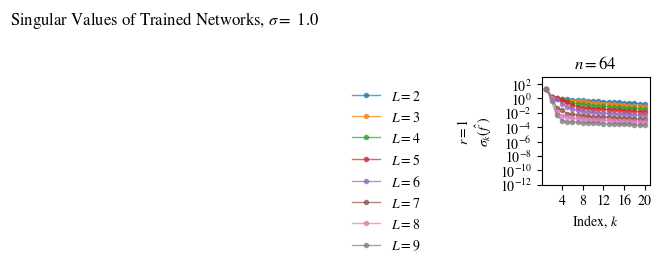

In [78]:
#all the singular values
for std in res.sigma.unique():
    f, ax = plt.subplots(nrows=len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(10,2.4))
    ax = np.array([[ax]])
    # if len(res.r.unique()) == 1: ax = ax[np.newaxis]
    for rownum,row in res.iterrows():
        if row['sigma'] == std:
            whichrow = np.where(row['r'] == res.r.unique())[0][0]
            whichcol = np.where(row['n'] == res.n.unique())[0][0]
            print(rf"{row['r']},{row['n']},{row['L']}",row["Gradient Singular Values"]/np.sqrt(2048),whichrow,whichcol)
            ax[whichrow,whichcol].semilogy(row["Gradient Singular Values"]/np.sqrt(2048),label=rf"$L={row['L']}$",linewidth=1,alpha=0.7,marker=".")
            ax[whichrow,whichcol].set_xticks(list(range(3,20,4)),list(range(4,21,4)))
            ax[whichrow,whichcol].set_ylim(10**-9,10**3)
            ax[0,whichcol].set_title(rf"$n={row['n']}$")
            ax[-1,whichcol].set_xlabel(rf"Index, $k$")
    plt.subplot(len(res.r.unique()),len(res.n.unique()),1)
    leg = plt.legend()
    leg = plt.legend(bbox_to_anchor=(-1, 1))
    leg.get_frame().set_edgecolor('b')
    leg.get_frame().set_linewidth(0.0)
    for rnum,r in enumerate(res.r.unique()):
        plt.subplot(len(res.r.unique()),len(res.n.unique()),1+rnum*len(res.n.unique()))
        plt.ylabel(f"$r={r}$"+"\n"+r"$\sigma_k(\hat f)$")
        plt.yticks([10**p for p in range(-12,3,2)])
    plt.suptitle(rf"Singular Values of Trained Networks, $\sigma =$ {std}")
    plt.tight_layout()
    plt.savefig(job_name+f"_labelnoise{std}_sv.pdf",dpi=300)
    plt.show()

## Plots of L vs Validation error

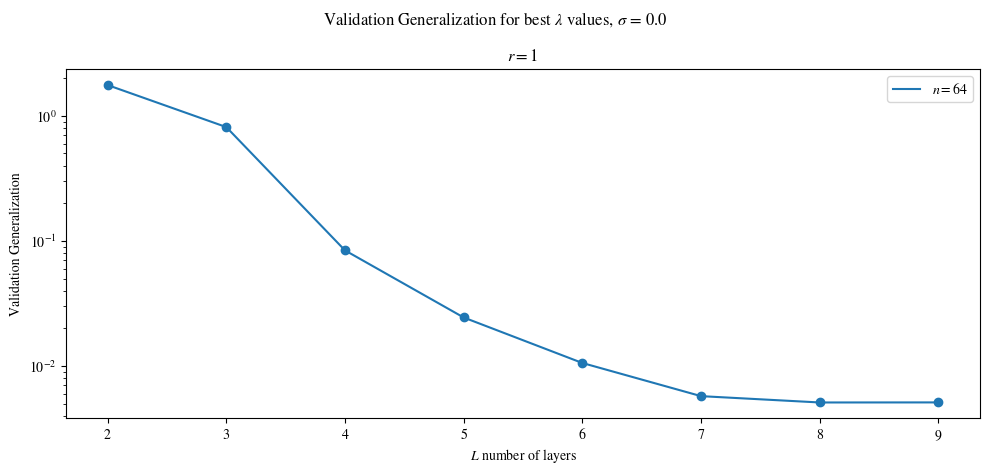

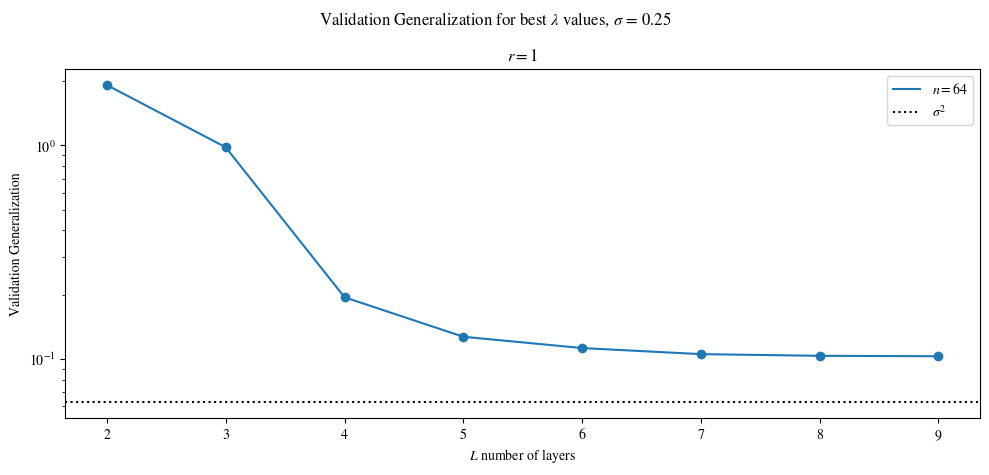

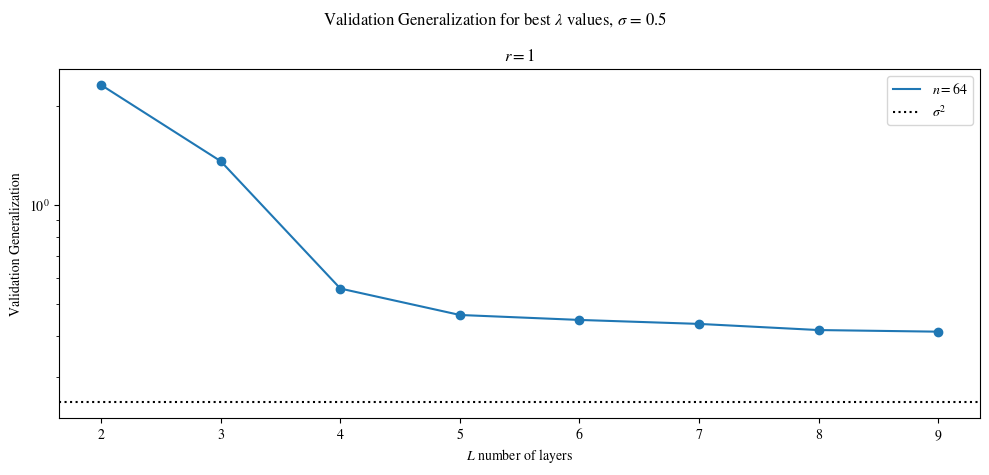

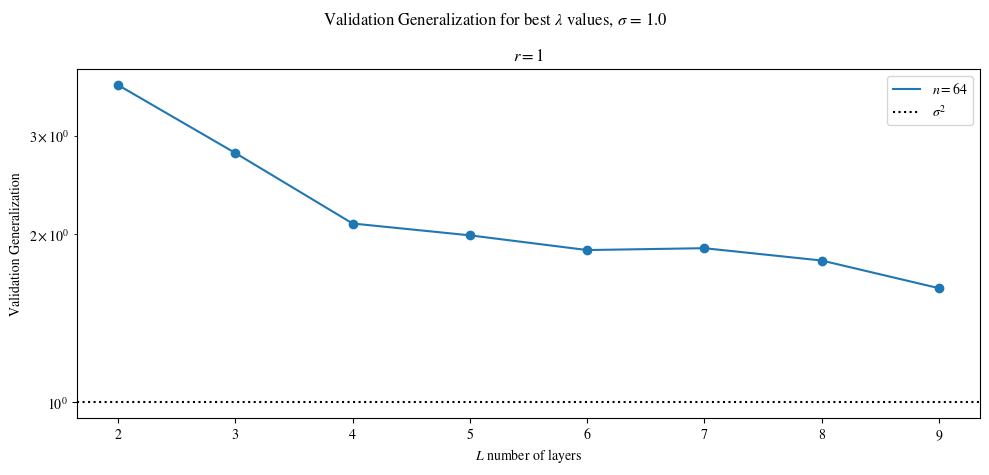

In [79]:
for std in res["sigma"].unique():
    f, ax = plt.subplots(ncols=len(res.r.unique()),nrows=1, sharex=True, sharey=False, figsize=(10,4.8))
    if len(res.r.unique()) == 1: ax = [ax]
    for rnum,r in enumerate(res.r.unique()):
        for n in res.n.unique():
                res_rnstd = res[(res.r == r) * (res.n == n) * (res["sigma"] == std)]
                ax[rnum].scatter(res_rnstd.L,res_rnstd[["Validation Generalization"]])
                ax[rnum].semilogy(res_rnstd.L,res_rnstd[["Validation Generalization"]],label=rf"$n={n}$")
                for _,model in res_rnstd.iterrows():
                    text = rf'$\lambda = {model["lambda"]:.0e}$' + f'\nfit {model["Final Train MSE"]:.1e}\nwd{model["Final Weight Decay"]:.1e}'
                    # ax[rnum].annotate(text,[model.L,model[["Validation Generalization"]]],fontsize=1)
        ax[rnum].set_xlabel("$L$ number of layers")
        ax[rnum].set_title(rf"$r={r}$")
        if std > 0:
            ax[rnum].axhline(y=std**2, color='k', linestyle=':',label="$\sigma^2$")
        ax[0].set_ylabel("Validation Generalization")
        f.suptitle(rf"Validation Generalization for best $\lambda$ values, $\sigma$ = {std}")
    ax[0].legend()
    f.tight_layout()
    if int(std) == std:
        std = int(std)
    f.savefig(job_name+f"_labelnoise{std}_ValidationMSE.pdf",dpi=300)
    plt.show()

## Performance metrics with/without linear layers

In [80]:
columnwidth = 6.17406722223
markersize = 4
colors = {  
    0   :"C0",
    0.25:"C1",
    0.5 :"C2",
    1   :"C3"
}
labels = {
    "without extra layers":"-",
    "with extra layers"   :"--",
}
markers = {
    "without extra layers":".",
    "with extra layers"   :"x",
}

### generalization

(1, 32)
(1, 32)
(1, 32)
(1, 32)
(1, 32)
(1, 32)
(1, 32)
(1, 32)


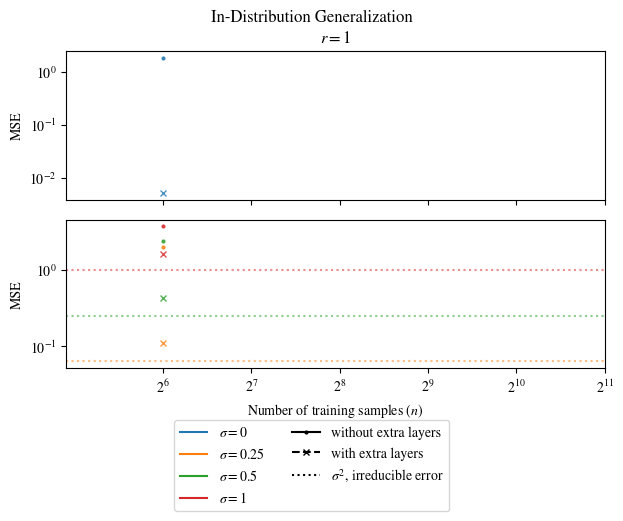

(1, 32)
(1, 32)
(1, 32)
(1, 32)
(1, 32)
(1, 32)
(1, 32)
(1, 32)


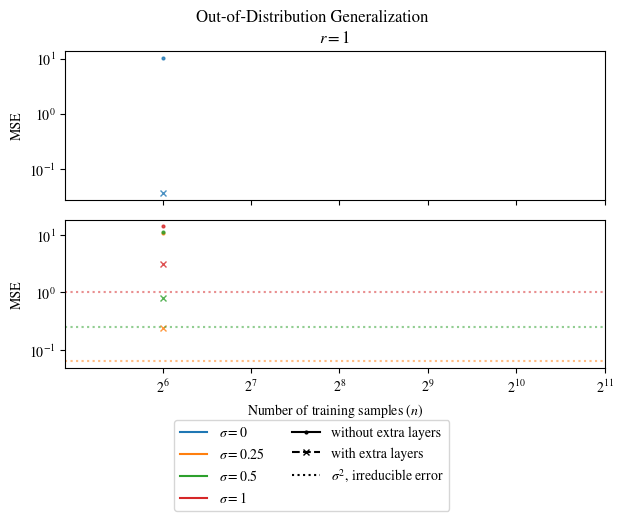

In [82]:
#generalization and OOD errors
handles = [
    Line2D([0], [0], color=color, ls='-', label=rf"$\sigma =${sigma}") for sigma,color in colors.items()
]
handles += [
    Line2D([0], [0], color='k', ls=ls, label=label, marker = markers[label], markersize=markersize) for label,ls in labels.items()
] 
handles += [
        Line2D([0], [0], color='k', ls=':', label='$\sigma^2$, irreducible error'),
]

for metric in ['In-Distribution','Out-of-Distribution']:
    standard_errors = metric[:-3] + 'SEM'
    f, ax = plt.subplots(ncols=len(res.r.unique()),nrows=2, sharex=True, sharey="row", figsize=(columnwidth,4.25))
    if len(res.r.unique()) == 1: ax = ax[:,np.newaxis]
    #just the data without label noise in the first row
    for col,r in enumerate(res.r.unique()):
        for row,sigmas in enumerate([[0],[0.25,0.5,1]]):
            for sigma in sigmas:
                for label,ls in labels.items():
                    if label == "with extra layers":#"with linear layers":
                        curr = bestLres[(bestLres.r == r) * (bestLres["sigma"]==sigma)]
                    elif label == "without extra layers":#"without linear layers":
                        curr = res[(res.L == 2) * (res.r == r) * (res["sigma"]==sigma)]
                    print(curr.shape)
                    points = curr[[metric + " Generalization"]].values[:,0]
                    marker = markers[label]
                    ax[row,col].plot(curr.n,points,
                                        linestyle=ls,
                                        marker=marker,
                                        markersize=markersize,
                                        color=colors[sigma],
                                        alpha=0.8)
                    #horizontal dashed line for minimal possible MSE (ie sigma^2) in plots with label noise
                    ax[1,col].axhline(y=sigma**2, color=colors[sigma], linestyle=':',alpha=0.3)
            #plot set up
            ax[row,col].set_xscale("log",base=2)
            ax[row,col].set_xticks([2**k for k in range(6,12)])
            ax[row,col].set_yscale("log",base=10)
            ax[row,0].set_ylabel(f"MSE",wrap=True)
            ax[0,col].set_title(rf"$r={r}$") 
            ax[1,col].set_xlabel("Number of training samples ($n$)")
            ax[row,col].minorticks_off()
    f.legend(handles=handles, ncol=2, loc = 'upper center', bbox_to_anchor=(0.5,0.03))
    plt.suptitle(f"{metric} Generalization")
    plt.tight_layout(pad=0.5,h_pad=1.08, w_pad=1.08)
    plt.savefig(job_name+f"{metric} Generalization.pdf",dpi=300,bbox_inches='tight')
    plt.show()

### singular values

1 64 0 0


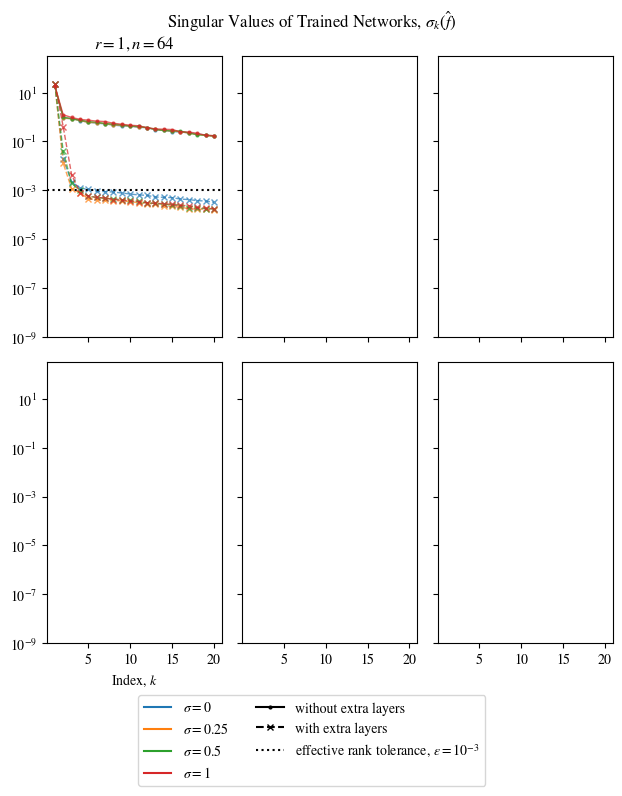

In [83]:
handles = [
    Line2D([0], [0], color=color, ls='-', label=rf"$\sigma =${sigma}") for sigma,color in colors.items()
]
handles += [
    Line2D([0], [0], color='k', ls=ls, label=label, marker = markers[label], markersize=markersize) for label,ls in labels.items()
] 
handles += [Line2D([0], [0], color='k', ls=':', label=r"effective rank tolerance, $\varepsilon = 10^{-3}$")]

ranktol = 1e-3
f, ax = plt.subplots(nrows=len(res.r.unique())*2, ncols=3, sharex=True, sharey=True, figsize=(columnwidth,7))#,5.75))
for rnum,r in enumerate(res.r.unique()):
    for nnum,n in enumerate(res.n.unique()):
        row = 2*rnum + nnum // 3
        col = nnum % 3
        print(r,n,row,col)
        for sigma in res.sigma.unique():
            for label,ls in labels.items():
                if label == "with extra layers":#"with linear layers":
                    curr = bestLres[(bestLres.r == r) * (bestLres.n == n) * (bestLres["sigma"] == sigma)]
                elif label == "without extra layers":#"without linear layers":
                    curr = res[(res.L == 2) * (res.n == n) * (res.r == r) * (res["sigma"]==sigma)]
                marker = markers[label]
                ax[row,col].semilogy(curr["Gradient Singular Values"].values[0]/np.sqrt(2048),
                    linestyle=ls,
                    linewidth=1,
                    alpha=0.7,
                    marker=marker,
                    markersize=markersize,
                    color=colors[sigma])
        ax[row,col].axhline(y=ranktol, color='k', linestyle=':',alpha=1, label = r"effective rank tolerance, $\varepsilon = 10^{-3}$")
        ax[row,col].set_xticks(list(range(4,20,5)),list(range(5,21,5)))
        ax[0,0].set_yticks([10**p for p in range(-9,3,2)])
        ax[row,col].set_title(rf"$r={r},n={n}$")
        ax[-1,col].set_xlabel(rf"Index, $k$")
        ax[row,col].set_ylim(10**(-9),10**(2.5))
f.legend(handles=handles, ncol=2, loc = 'upper center', bbox_to_anchor=(0.5,0.01))
plt.suptitle(r"Singular Values of Trained Networks, $\sigma_k(\hat{f})$")
plt.tight_layout(pad=0.5,h_pad=1.08, w_pad=1.08)
plt.savefig(job_name+f"_labelnoise_sv.pdf",dpi=300, bbox_inches='tight')
plt.show()
handles.pop()

### active subspaces

0.0
0.25
0.5
1.0
0.0
0.25
0.5
1.0


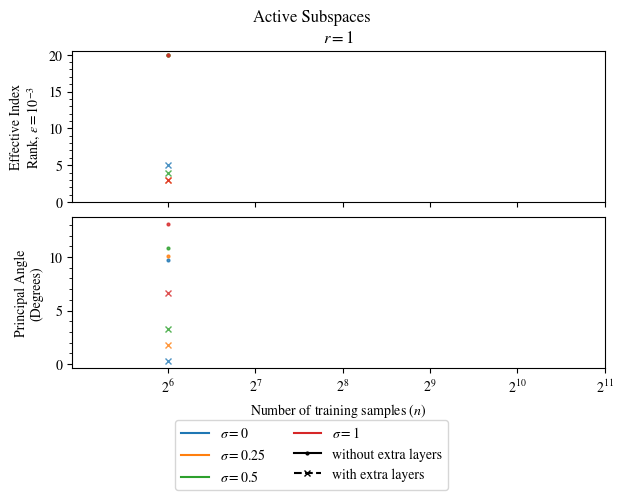

In [84]:
handles = [
    Line2D([0], [0], color=color, ls='-', label=rf"$\sigma =${sigma}") for sigma,color in colors.items()
]
handles += [
    Line2D([0], [0], color='k', ls=ls, label=label, marker = markers[label], markersize=markersize) for label,ls in labels.items()
] 

#active subspace error plot
f, ax = plt.subplots(ncols=len(res.r.unique()),nrows=2, sharex=True, sharey=False, figsize=(columnwidth,4.25))
if len(res.r.unique()) == 1: ax = ax[:,np.newaxis]
for row,metric in enumerate([r"Effective Index Rank, $\varepsilon = 10^{-3}$","Principal Angle (Degrees)"]):
    for col,r in enumerate(res.r.unique()):
        for sigma in res.sigma.unique():
            print(sigma)
            for label,ls in labels.items():
                if label == "with extra layers":#"with linear layers":
                    curr = bestLres[(bestLres.r == r) * (bestLres["sigma"] == sigma)]
                elif label == "without extra layers":#"without linear layers":
                    curr = res[(res.L == 2) * (res.r == r) * (res["sigma"]==sigma)]
                if metric == "Principal Angle (Degrees)":
                    points = curr[[metric]].values[:,0]
                elif metric == r"Effective Index Rank, $\varepsilon = 10^{-3}$":
                    points = (np.array(curr["Gradient Singular Values"].tolist())/np.sqrt(2048) > ranktol).sum(axis=1)
                    ax[row,col].set_yticks(np.arange(0,21,5))
                    ax[row,col].set_ylim(0,20.5)
                marker = markers[label]
                ax[row,col].plot(curr.n,points,
                                    linestyle=ls,
                                    color=colors[sigma],
                                    marker=marker,
                                    markersize=markersize,
                                    alpha=0.8)
                # for (_,model),y in zip(curr.iterrows(),points):
                #     text = rf'$\lambda = {model["lambda"]:.0e}$' + f'\nL = {model["L"]}\nfit {model["Final Train MSE"]:.1e}\nwd{model["Final Weight Decay"]:.1e}\nVal{model["Validation MSE"]:.1e}'
                #     ax[row,col].annotate(text,[model["n"],y],fontsize=1)
        #plot set up
        ax[row,0].set_ylabel(metric[:15] + '\n' + metric[16:])
        ax[0,col].set_title(rf"$r={r}$") 
        ax[0,col].set_yticks(range(21), minor=True)
        ax[row,col].set_xscale("log",base=2)
        ax[row,col].set_xticks([2**k for k in range(6,12)])
        ax[1,col].set_xlabel("Number of training samples ($n$)")
        ax[row,col].minorticks_on()
f.legend(handles=handles, ncol=2, loc = 'upper center', bbox_to_anchor=(0.5,0.03))
plt.suptitle(f"Active Subspaces")
plt.tight_layout(pad=0.5,h_pad=0.5, w_pad=0.5)
plt.savefig(job_name+f"Active Subspaces.pdf",dpi=300,bbox_inches='tight')
plt.show()